In [68]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import optuna


from ctgan import CTGAN
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from pycaret.regression import *
from pycaret.regression import setup

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

from sklearn.manifold import TSNE

from sklearn.metrics import log_loss






In [69]:
import lightgbm as lgb


In [70]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df = train_df.drop(['id'], axis=1)
X_df = train_df.drop(['target'], axis=1)
y_df = train_df['target']
dict_for_y = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
y_df = y_df.map(dict_for_y)


In [71]:
cols = [col for col in X_df.columns if col not in ['id', 'target']]
def feat_eng(data, cols):
    
    data['max_val'] = data[cols].max(axis=1) 
    data['sum_val'] = data[cols].sum(axis=1)
    data['mean_val'] = data[cols].mean(axis=1)
    data['std_val'] = data[cols].std(axis=1)
    data['median_val'] = data[cols].median(axis=1)
    data['skew_val'] = data[cols].skew(axis=1)
    data['kurt_val'] = data[cols].kurtosis(axis=1)
    data['count_one'] = (data[cols] == 1).sum(axis=1)
    data['count_two'] = (data[cols] == 2).sum(axis=1)
    data['count_three'] = (data[cols] == 3).sum(axis=1)
    data['count_over'] = (data[cols] >= 3).sum(axis=1)
    data['count_zero'] = (data[cols] == 0).sum(axis=1)
    # data['count_one_ratio'] = data['count_one'] / data['max_val']
    # data['count_two_ratio'] = data['count_two'] / data['max_val']
    # data['count_three_ratio'] = data['count_three'] / data['max_val']
    # data['count_four_ratio'] = data['count_four'] / data['max_val']
    # data['count_five_ratio'] = data['count_five'] / data['max_val']
    # data['count_zero_ratio'] = data['count_zero'] / data['max_val']

    # data['max_min_diff'] = data['max_val'] - data[cols].min(axis=1)
    # data['max_min_ratio'] = data['max_val'] / data[cols].min(axis=1)
    # data['max_std_ratio'] = data['max_val'] / data['std_val']
    # data['max_mean_ratio'] = data['max_val'] / data['mean_val']
    # data['max_median_ratio'] = data['max_val'] / data['median_val']
    # data['max_skew_ratio'] = data['max_val'] / data['skew_val']
    # data['max_kurt_ratio'] = data['max_val'] / data['kurt_val']
    # data['max_sum_ratio'] = data['max_val'] / data['sum_val']
    # data['max_over_ratio'] = data['max_val'] / data['count_over']
    # data['max_zero_ratio'] = data['max_val'] / data['count_zero']
    # data['max_one_ratio'] = data['max_val'] / data['count_one']
    # data['max_two_ratio'] = data['max_val'] / data['count_two']
    # data['max_three_ratio'] = data['max_val'] / data['count_three']
    # data['max_four_ratio'] = data['max_val'] / data['count_four']
    # data['max_five_ratio'] = data['max_val'] / data['count_five']
    # data['min_mean_diff'] = data[cols].min(axis=1) - data['mean_val']
    # data['min_std_diff'] = data[cols].min(axis=1) - data['std_val']


    return data

X_df = feat_eng(X_df, cols)

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X_df, y_df, test_size=0.1, stratify=y_df, random_state=42)

In [73]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_train = pd.DataFrame(X_train)
X_valid = pd.DataFrame(X_valid)

In [74]:
params = {
    'boosting_type': 'gbdt',
    'objective':'multiclass',
    'metric':'multi_logloss',
    'verbosity': 10,
    'num_class':4,
    'learning_rate':0.005,
    'num_iterations':1000,
    'early_stopping_round':100,
}

In [75]:
model = lgb.LGBMClassifier(**params)
callbacks = []

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], callbacks=callbacks)


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.824257
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.641306
[LightGBM] [Debug] init for col-wise cost 0.007782 seconds, init for row-wise cost 0.011000 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 61
[LightGBM] [Info] Start training from score -2.466281
[LightGBM] [Info] Start training from score -0.553443
[LightGBM] [Info] Start training from score -1.540845
[LightGBM] [Info] Start training from score -2.072003
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

LGBMClassifier(early_stopping_round=100, learning_rate=0.005,
               metric='multi_logloss', num_class=4, num_iterations=1000,
               objective='multiclass', verbosity=10)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

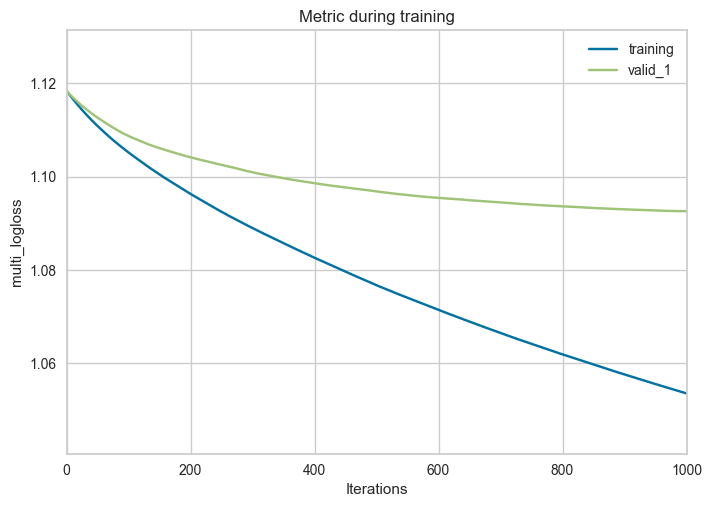

In [76]:
lgb.plot_metric(model)


In [85]:
importance_type = 'gain'
print(model.feature_importances_)

[1346 1661 1425 1266 1206 1961 2176 1749 1282 2472 1427 1476 1929 1017
 4539 3084 1976 1407 2062 1824 1337 1321 1320 1353 1767 1411 1727 1268
 2794 1276 1881 2700 2008 1736 4039 1866 1280 1742 4101 1996 1688 1478
 1856 2609 1066 1436 1512 1637 2165 1313 1721 4262    0 4577    0 3920
 3252 1985 1551 1099 1700 2965]


In [77]:
# cols = [col for col in X_train.columns if col not in ['id', 'target']]
# X_train = feat_eng(X_train, cols)
# X_valid = feat_eng(X_valid, cols)

In [78]:
# pca = PCA(n_components=0.9)
# pca.fit(X_train)
# X_train= pca.transform(X_train)
# X_valid = pca.transform(X_valid)


In [79]:
# training by tabnet

X_train = X_train.values
X_valid = X_valid.values
y_train = y_train.values
y_valid = y_valid.values



In [80]:
# Tabnet claasification
tabnet_parms = dict(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), device_name='cuda' if torch.cuda.is_available() else 'cpu', mask_type='sparsemax')
tabnet_pretrainer = TabNetPretrainer(**tabnet_parms)

tabnet_pretrainer.fit(X_train, eval_set=[X_valid], max_epochs=1000, patience=10, batch_size=2048)



epoch 0  | loss: 88.36279| val_0_unsup_loss_numpy: 1.018530011177063|  0:00:05s
epoch 1  | loss: 1.03006 | val_0_unsup_loss_numpy: 0.9791100025177002|  0:00:11s
epoch 2  | loss: 0.96758 | val_0_unsup_loss_numpy: 0.9918000102043152|  0:00:16s
epoch 3  | loss: 0.96362 | val_0_unsup_loss_numpy: 0.9777299761772156|  0:00:22s
epoch 4  | loss: 0.95408 | val_0_unsup_loss_numpy: 0.9586099982261658|  0:00:28s
epoch 5  | loss: 1.01132 | val_0_unsup_loss_numpy: 0.9470599889755249|  0:00:33s
epoch 6  | loss: 0.95636 | val_0_unsup_loss_numpy: 0.9259499907493591|  0:00:39s
epoch 7  | loss: 0.92678 | val_0_unsup_loss_numpy: 0.9142400026321411|  0:00:45s
epoch 8  | loss: 0.92248 | val_0_unsup_loss_numpy: 0.9106799960136414|  0:00:51s
epoch 9  | loss: 0.92102 | val_0_unsup_loss_numpy: 0.8893399834632874|  0:00:57s
epoch 10 | loss: 0.91776 | val_0_unsup_loss_numpy: 0.8813899755477905|  0:01:03s
epoch 11 | loss: 0.91232 | val_0_unsup_loss_numpy: 0.8789399862289429|  0:01:09s
epoch 12 | loss: 0.90236 | va

In [95]:
optim_class = torch.optim.SGD

model_tabnet = TabNetClassifier(
    optimizer_fn=optim_class,
    optimizer_params=dict(lr=1e-1, weight_decay=1e-5),
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    seed=42,
    verbose=10,

)

model_tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)], batch_size=2048, max_epochs=1000, patience=10, from_unsupervised=tabnet_pretrainer, eval_metric=['logloss'], loss_fn=nn.CrossEntropyLoss())

epoch 0  | loss: 1.66957 | val_0_logloss: 1.39765 | val_1_logloss: 1.39656 |  0:00:07s
epoch 10 | loss: 1.11527 | val_0_logloss: 1.11377 | val_1_logloss: 1.1136  |  0:01:22s
epoch 20 | loss: 1.11479 | val_0_logloss: 1.11339 | val_1_logloss: 1.11375 |  0:02:32s

Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_1_logloss = 1.11345


In [94]:
y_pred_tabnet = model_tabnet.predict_proba(X_valid)
log_loss(y_valid, y_pred_tabnet)

1.1132346737413092

In [83]:
y_pred = model.predict_proba(X_train)
print(log_loss(y_train, y_pred))

1.053622091921083


In [84]:
y_pred = model.predict_proba(X_valid)
print(log_loss(y_valid, y_pred))

1.092600393653089


In [86]:
y_merge = (y_pred + y_pred_tabnet) / 2
print(log_loss(y_valid, y_merge))

1.0987812526021687
